## Comic Book Covers
### Image & Metadata Analysis

Exploratory data analysis of comic book images and metadata scraped from `https://comics.org`.

In [412]:
import os
import pandas as pd
from PIL import Image

from comics_net import analyzer

Describe the issue metadata of all comic books scraped thus far.

In [413]:
# load the metadata
df = analyzer.load_metadata('../metadata/covers.jsonl')

# parse issue number and cast as int
df['issue_number'] = df['title'].apply(analyzer.get_issue_number_from_title)

# describe categorical metadata features
df.drop(['issue_number', 'covers'], axis=1).describe().T

,count,unique,top,freq
format_binding,59401,119,Saddle-stitched,23284
format_color,59401,63,Color,30583
format_dimensions,59401,162,standard Modern Age US,12136
format_paper_stock,59401,188,,15234
format_publishing_format,59401,92,was ongoing series,23092
indexer_notes,59401,33430,,13187
indicia_frequency,59401,911,monthly,28033
issue_brand,59401,212,DC [bullet],11495
issue_indicia_publisher,59401,132,DC Comics,15699
issue_pages,59401,200,36,40487


## Character Labels

Each comic book contains some issue metadata (shown above) and some cover image-specific metadata, as some issues contain variant covers drawn  by different artists and containing different characters.

Below we unpack the covers metadata and parse the list of characters appearing on each cover (and variant).

In [414]:
from comics_net.webscraper import strip_brackets

# create cover df
covers_dict = df["covers"].to_dict()

# add dataframe index to cover image-level metadata
for d1 in covers_dict:
    for d2 in covers_dict[d1]:
        covers_dict[d1][d2]["index"] = d1
        
# unpack cover image-level metadata
df_covers = pd.concat([pd.DataFrame(x).T for x in covers_dict.values()], axis=0)

# join cover-image-level metadata back with issues metadata
df = pd.merge(df.reset_index(),
              df_covers,
              how='outer',
              on='index').\
    sort_values(["series_name", "issue_number"], ascending=True).\
    drop(["index", "covers"], axis=1).\
    reset_index(drop=True).\
    copy()

# convert cover_characters string to list
def map_convert_characters_to_list(characters: str):
    if characters is np.nan:
        return np.nan
    else:
        return analyzer.convert_characters_to_list(characters)

# listify character string
df["cover_characters_list"] = df["cover_characters"].apply(map_convert_characters_to_list)

# get list of unique characters
unique_characters = pd.Series(analyzer.flatten(df["cover_characters_list"].dropna().values)).value_counts().index

# create character alias dict
aliases = {k: v for k, v in zip(unique_characters, [strip_brackets(x) for x in unique_characters])}

# convert cover_characters string to list
def map_aliases(characters_list: str):
    if characters_list is np.nan:
        return np.nan
    else:
        return [aliases[character] for character in characters_list]
    
# apply aliases to character names
df["cover_characters_list_aliases"] = df["cover_characters_list"].apply(lambda x: map_aliases(x))

# drop interim calc. fields
df = df.drop("cover_characters_list", axis=1)

# where synopisis is blank, replace w/ NaN
df.loc[df["synopsis"] == "", "synopsis"] = np.nan

# describe issue and cover metadata
df.drop(['issue_number', 'cover_characters_list_aliases'], axis=1).describe().T

,count,unique,top,freq
format_binding,71226,119,Saddle-stitched,30189
format_color,71226,63,Color,39179
format_dimensions,71226,162,Standard Modern Age US,16187
format_paper_stock,71226,188,,18889
format_publishing_format,71226,92,was ongoing series,25461
indexer_notes,71226,33430,,13187
indicia_frequency,71226,911,monthly,32468
issue_brand,71226,212,Marvel [white on red],12450
issue_indicia_publisher,71226,132,DC Comics,18664
issue_pages,71226,200,36,46098


In [415]:
# TODO: remove redundant images

#  parse variant description from title
df["title_variant"] = df["title"].apply(lambda  x: " ".join([x.replace("[", "").replace("]", "") for x in analyzer.match_brackets(x).keys()]))

# parse base description from title
temp = df["title"].apply(lambda  x: [v["start"] for k, v in analyzer.match_brackets(x).items()]).values
df["title_base"] = [t[0][:t[1]].replace("[", "").replace("]", "").strip() for t in list(zip(df["title"], [x[0] if len(x) > 0 else 0 for x in temp]))]

# update base title where no variant
df.loc[df["title_base"]=="", "title_base"] = df.loc[df["title_base"]=="", "title"]

# count instances of base descriptions
title_base_counts = df["title_base"].value_counts().reset_index()
title_base_counts.columns = ["title_base", "title_base_count"]

# merge count of base titles
df = pd.merge(df, title_base_counts, how="left", on="title_base").sort_values("title_base_count", ascending=False)

In [416]:
# # update base title where no variant
# df.loc[df["title_base"]=="", "title_base"] = df.loc[df["title_base"]=="", "title"]

In [417]:
# convert cover_characters string to list

#TODO: remove brackets from artists name, listify multiple artists, additional cleanup, etc...
def clean_cover_pencils(pencils: str):
    if pencils is np.nan:
        return np.nan
    else:
        return pencils.\
    replace("(signed)", "").\
    replace("(sketch)", "").\
    replace("(credited)", "").\
    replace("(painted)", "").\
    replace("(painting)", "").\
    replace("(credited, signed)", "").\
    replace("(signed, credited)", "").\
    replace("[as GK]", "").\
    strip()
    
df["cover_pencils_cleaned"] = df["cover_pencils"].apply(clean_cover_pencils)

In [425]:
# filter for only those issues having variants / dupes
df_variants = df[df["title_base_count"] > 1].sort_values(["title", "issue_number"])

df_non_variants = df[(df["title_base_count"] == 1)].sort_values(["title", "issue_number"])

df_variants_artists = df_variants.groupby(["title_base", "cover_pencils_cleaned"]).apply(len).reset_index()

df_variants_artists.columns = ["title_base", "cover_pencils_cleaned", "cover_pencils_cleaned_count"]

In [432]:
"Of {} total covers, {} are either variants or redundant and {} are unique".format(len(df_variants) + len(df_non_variants), len(df_variants), len(df_non_variants))

'Of 71226 total covers, 28773 are either variants or redundant and 42453 are unique'

The goal is to parse through the 28K+ covers and keep variant covers and discard redundant ones.

In [433]:
thingy1 = pd.merge(df_variants, df_variants_artists, how="left", on=["title_base", "cover_pencils_cleaned"])

thingy1 = thingy1[thingy1["cover_pencils_cleaned_count"] == 1.0].drop("cover_pencils_cleaned_count", axis=1)

thingy1 = pd.concat([df_non_variants, thingy1], axis=0)

In [459]:
#TODO: reason about which save_to's to keep

thingy2 = pd.merge(df_variants, df_variants_artists, how="left", on=["title_base", "cover_pencils_cleaned"])

thingy2 = thingy2[thingy2["cover_pencils_cleaned_count"] > 1.0].\
            groupby(["title_base"]).\
            apply(lambda x: "; ".join(x["save_to"].values)).\
            reset_index()

thingy2.columns = ["title_base", "save_to_concat"]

In [605]:
# thingy2

In [597]:
# if there are 2 covers and one had "Original" and the other has "Variant", keep both
# if there are more than 1 covers with the same date, and one "Sketch"
# if there are 2 covers with the same name and one has a date, and one does not, keep the one with the date
# if there are 2 covers with the same name and one has a date, and one has a year, keep the one with the date
# if there are 2 covers and one has "Direct" sales and one has "Zero Hour", keep the Zero Hour
# if there are 2 covers and one has "Direct" sales and one has "DC Universe", keep the DC Universe one
# if there are 2 covers and one has "Original" and one has "British", keep zero hour logo
# if variant name has "Blank Cover", exclude it

In [1964]:
from pandas import DataFrame

def match_parens(s: str) -> dict:
    """
    Given a string return a dict identifying the spans of bracketed 
    text, where the keys are the bracketed text and the values are 
    dicts with keys: (start, end) indicating the start and end
    location in the string of the bracketed text.
    """
    p = re.compile(r"\((.*?)\)")
    matches = {}
    for m in p.finditer(s):
        matches[m.group()] = {"start": m.start(), "end": m.end()}
    return matches

def match_dates(s: str) -> bool:
    """
    Given a string return a bool indicating whether the span of text
    contains date formatted in YYYY-MM-DD
    """
    match = re.search('\d{4}-\d{2}-\d{2}', s)
    if match is None:
        return False
    else:
        return True
    
def calc_aggregate_counts(df: DataFrame, aggregate_fields: list, count_field_name: str) -> DataFrame:
    """
    Given a DataFrame calculate counts over a field to aggregate by. 
    """
    df_counts = df.groupby(aggregate_fields).apply(len).reset_index()
    df_counts.columns = aggregate_fields + [count_field_name]
    return pd.merge(df, df_counts, how='left')


def remove_2_issue_missing_date(df: DataFrame) -> DataFrame:
    """
    If there are 2 covers with the same base name and one has a date, and one does not, 
    keep the one with the date.
    """
    save = []
    counter = 0
    for issue in df["base_issue"].unique():
        issue_slice = df[df["base_issue"] == issue]
        if len(issue_slice) == 1:
            pass
        else:
            has_empty_date = max(issue_slice["date"] == "()")
            has_nonempty_date = max(issue_slice["date"].apply(match_dates))
            if has_empty_date & has_nonempty_date:
                counter += 1
                save.append(issue_slice[issue_slice["date"] != "()"])
    if counter > 0:
        print("Found similar base issues w/ one missing a date".format())
        deduped_df = pd.concat(save, axis=0).reset_index(drop=True).drop("base_issue_count", axis=1)
        unique_df = df[df["base_issue_count"] == 1].drop("base_issue_count", axis=1)
        if len(unique_df) == 0:
            return deduped_df
        else:
            return pd.concat([deduped_df, unique_df], axis=0)
    if counter == 0:
        return df.drop("base_issue_count", axis=1)

def remove_2_issue_redundancy(df: DataFrame, text_1: str, text_2: str) -> DataFrame:
    """
    If there are 2 covers and the `base_issue` field in one has "text_1" and the other has "text_2", 
    only keep the issue having "text_1".
    """
    save = []
    has_text_1 = max(df["base_issue"].apply(lambda x: text_1 in x))
    has_text_2 = max(df["base_issue"].apply(lambda x: text_2 in x))
    if has_text_1 & has_text_2:
        save.append(df[df["base_issue"].apply(lambda x: text_1 in x)])
        print("Found redundant issues {} and {}".format(text_1, text_2))
        return pd.concat(save, axis=0).drop("base_issue_count", axis=1)
    else:
        return df.drop("base_issue_count", axis=1)

In [1972]:
import re

# i = 0

l = thingy2.iloc[i]["save_to_concat"].split("; ")
l.sort()

i += 1
print(i)

def filter_save_to_concats(l: list):
    
    # some text pre-processing (there's kruft...)
    l = [x.replace(" ?)", ")") for x in l]
    
    # parse issue publish dates from file path
    dates = [list(match_parens(x).keys())[0] for x in l]
    
    # create list of base issue names (e.g.. the issue name excluding file path dirs and publish date)
    base_issues = [t[0].replace(" " + t[1], "").replace("./covers/", "").strip() for t in zip(l, dates)]
    
    # create DataFrame of file paths, base issue names, and publish dates
    df = pd.DataFrame(data=list(zip(l, base_issues, dates)), columns=["save_to", "base_issue", "date"])
    df = df.drop_duplicates()
    
    # count unique base issues and append to DataFrame
    df = calc_aggregate_counts(df=df, aggregate_fields=["base_issue",  "date"], count_field_name="base_issue_count")

    
    
    # Rule 0: weird one off thing for Spiderman #1
    if len(df) > 150:
        df = df.groupby("base_issue").apply(min)
        return df.reset_index(drop=True).drop("base_issue_count", axis=1)
    
    
    # Rule 1: remove_2_issue_missing_date
    has_multiple_base_issues = max(df["base_issue_count"] > 1)
    if has_multiple_base_issues:
        df = remove_2_issue_missing_date(df)

    # the dataframe has mutated, so recalculate aggregate fields...
    df = calc_aggregate_counts(df=df, aggregate_fields=["base_issue",  "date"], count_field_name="base_issue_count")
    has_multiple_base_issues = max(df["base_issue_count"] > 1)


    

            
    # Rule 2: last ditch attempt to dedupe
    save = []
    if (not has_multiple_base_issues) & (len(df) == 2):
        has_original = max(df["base_issue"].apply(lambda x: "Original" in x))
        has_1_empty_date = sum(df["date"] == "()") == 1
        has_2_empty_date = sum(df["date"] == "()") == 2
        if has_original & has_1_empty_date:
            save.append(df[df["date"] != "()"])
            df = pd.concat(save,  axis=0).drop("base_issue_count", axis=1)
        if has_original & has_2_empty_date:
            save.append(df[df["date"] == "()"])
            df = pd.concat(save,  axis=0).drop("base_issue_count", axis=1)
            print("rule 2")
            
    # the dataframe has mutated, so recalculate aggregate fields...
    df = calc_aggregate_counts(df=df, aggregate_fields=["base_issue",  "date"], count_field_name="base_issue_count")
    has_multiple_base_issues = max(df["base_issue_count"] > 1)
            
        

            
    # Rule 3:
    save = []
    has_direct = max(df["base_issue"].apply(lambda x: "Direct Sales" in x))
    has_dc = max(df["base_issue"].apply(lambda x: "DC Universe" in x))
    if (len(df) == 4) &  (has_direct) & (has_dc):
        nonempty_dates = df["date"].apply(match_dates)
        dc_universe = df["base_issue"].apply(lambda x: "DC Universe" in x)
        save.append(df[nonempty_dates & dc_universe])
        df = pd.concat(save,  axis=0).drop("base_issue_count", axis=1)
        print("rule 3")
    
    # the dataframe has mutated, so recalculate aggregate fields...
    df = calc_aggregate_counts(df=df, aggregate_fields=["base_issue",  "date"], count_field_name="base_issue_count")
    has_multiple_base_issues = max(df["base_issue_count"] > 1)
    
    
    
    
    # Rule 4: weird one off thing for Action Comics #1
    new_save = []
    if len(df) > 2:
        df_count = df.groupby(["base_issue"]).apply(len).reset_index()
        df_count.columns = ["base_issue", "base_issue_count"]
        df = pd.merge(df.drop("base_issue_count", axis=1), df_count, how='left')
        df.columns = ["save_to", "base_issue", "date", "base_issue_count"]
        if max(df["base_issue_count"] > 1):
            for issue in df["base_issue"].unique():
                temp = df[df["base_issue"] == issue]
                has_empty_date = max(temp["date"] == "()")
                has_year_date = max(temp["date"] == "(2013)")
                has_nonempty_date = max(temp["date"].apply(match_dates))
                if (has_empty_date | has_year_date) & has_nonempty_date:
                    new_save.append(temp[(temp["date"] != "()") & (temp["date"] != "(2013)")])
            df = pd.concat([df[df["base_issue_count"] == 1], pd.concat(new_save, axis=0)], axis=0).drop("base_issue_count", axis=1)
            print("rule 4")
   


    
    # Rule 5: remove_2_issue_redundancy
    redundancy_rules = [
        {"text_1":"Direct", "text_2":"DC Universe"},
        {"text_1":"Direct", "text_2":"British"},
        {"text_1":"Direct", "text_2":"No Barcode"},
        {"text_1":"Direct", "text_2":"Bullet"},
        {"text_1":"Original", "text_2":"British"},
        {"text_1":"Original", "text_2":"Direct"},
        {"text_1":"25¢", "text_2":"30¢"},
        {"text_1":"Regular", "text_2":"British"}
    ]
    
    for rule in redundancy_rules:
        if len(df) == 1:
            pass
        if len(df) == 2:
            # the dataframe has mutated so recalculate counts
            df = calc_aggregate_counts(df=df, aggregate_fields=["base_issue", "date"], count_field_name="base_issue_count")
            has_unique_base_issues = max(df["base_issue_count"] == 1)

            if has_unique_base_issues:
                df = remove_2_issue_redundancy(df, rule["text_1"], rule["text_2"])
            
    return df.reset_index(drop=True)

filter_save_to_concats(l)

16


,save_to,base_issue,date
0,./covers/Action Comics: Action Comics #2 1:200...,Action Comics: Action Comics #2 1:200 Incentiv...,(2011-10-05)
1,./covers/Action Comics: Action Comics #2 Origi...,Action Comics: Action Comics #2 Original.jpg,(2011-10-05)


In [1973]:
l

['./covers/Action Comics: Action Comics #2 1:200 Incentive Cover Edition (2011-10-05).jpg',
 './covers/Action Comics: Action Comics #2 Original (2011-10-05).jpg']

In [635]:
# TODO: debug character list (some parsing is not working exactly right)

#TODO: pre-process artist, colors, pencils, etc... metadata (remove signed, etc...)


In [179]:
# create character count dict
character_counts = {k: v for k, v in 
                    zip(pd.Series(analyzer.flatten(df["cover_characters_list_aliases"].dropna().values)).value_counts().index,
                        pd.Series(analyzer.flatten(df["cover_characters_list_aliases"].dropna().values)).value_counts().values)}

# character_counts.keys()

In [180]:
df[df["synopsis"] != ""]["series_name"].value_counts()[:20]

Action Comics                 1006
Superman                       669
Detective Comics               585
The Amazing Spider-Man         522
Adventure Comics               449
Fantastic Four                 448
Batman                         438
Thor                           396
Justice League of America      390
Wonder Woman                   381
The Incredible Hulk            358
Green Lantern                  356
Conan the Barbarian            329
The Avengers                   294
Wolverine                      283
The Uncanny X-Men              271
Marvel Tales                   257
Superboy                       250
Adventures of Superman         234
The Spectacular Spider-Man     232
Name: series_name, dtype: int64

In [181]:
" ".join(df[(df["synopsis"] != "") &  (df["series_name"] == "Action Comics")]["synopsis"].values)[:5000]

"Superman finally puts a stop to Conduit. Superman finally puts a stop to Conduit. Superman finally puts a stop to Conduit. Superman finally puts a stop to Conduit. The story of Superman's first outing as Superman in Metropolis.  Superman gets knocked out by an RPG and a kid steals his cape. Meanwhile, Clark Kent moves into his new apartment and meets his landlady. The kids saves his friend from an abusive father, but almost dies in the process. Luckily Superman is there to save him. | A young professor meets a young Captain Comet and learns his secrets. The story of Superman's first outing as Superman in Metropolis.  Superman gets knocked out by an RPG and a kid steals his cape. Meanwhile, Clark Kent moves into his new apartment and meets his landlady. The kids saves his friend from an abusive father, but almost dies in the process. Luckily Superman is there to save him. | A young professor meets a young Captain Comet and learns his secrets. The story of Superman's first outing as Sup

In [5]:
covers = os.listdir('../covers/')

dims = []
for cover in covers:
    im = Image.open('../covers/' + cover)
    width, height = im.size
    dims.append((width, height))
    
"Calculated dims for {} covers".format(len(dims))

'Calculated dims for 64234 covers'

In [6]:
n = 60
pct = pd.Series(pd.Series(dims).value_counts() / len(dims)).cumsum()[:n].tail(1).values[0] * 100
print('Top {} image sizes account for {}% of covers'.format(n, round(pct, 1)), '\n')

top_dims = pd.Series(pd.Series(dims).value_counts() / len(dims)).cumsum()[:n].index
top_dims

print('Top Image Sizes:')
print(top_dims.values, '\n')
print('Height distribution:')
print('mean', round(pd.Series(map(lambda x: x[1], top_dims)).mean(), 0))
print('median', round(pd.Series(map(lambda x: x[1], top_dims)).median(), 0))
print('min', round(pd.Series(map(lambda x: x[1], top_dims)).min(), 0))
print('max', round(pd.Series(map(lambda x: x[1], top_dims)).max(), 0))
print('std', round(pd.Series(map(lambda x: x[1], top_dims)).std(), 0))

Top 60 image sizes account for 94.0% of covers 

Top Image Sizes:
[(400, 615) (400, 616) (400, 614) (400, 618) (400, 617) (400, 613)
 (400, 619) (400, 612) (400, 620) (400, 607) (400, 611) (400, 621)
 (400, 610) (400, 608) (400, 622) (400, 606) (400, 609) (400, 623)
 (400, 624) (400, 600) (400, 604) (400, 605) (400, 603) (400, 625)
 (400, 602) (400, 601) (400, 598) (400, 626) (400, 597) (400, 596)
 (400, 599) (400, 594) (400, 595) (400, 591) (400, 593) (400, 627)
 (400, 628) (400, 590) (400, 592) (400, 588) (400, 589) (400, 587)
 (400, 586) (400, 585) (400, 583) (400, 584) (400, 629) (400, 579)
 (400, 582) (400, 634) (400, 581) (400, 578) (400, 580) (400, 630)
 (400, 577) (400, 546) (400, 576) (400, 574) (400, 575) (400, 573)] 

Height distribution:
mean 601.0
median 602.0
min 546
max 634
std 19.0


### Show a random comic book cover

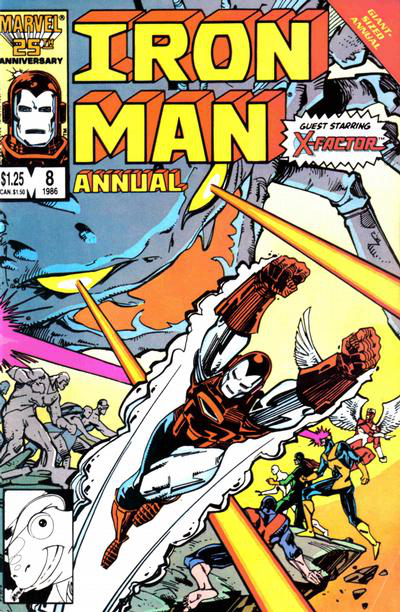

In [123]:
# TODO: update get_random_sample_of_covers to drop duplicate images
# TODO: update get_random_sample_of_covers to include cover metadata

random_cover = analyzer.get_random_sample_of_covers(df_cover_characters, character="Iron Man", n=1)

image_path = random_cover[list(random_cover.keys())[0]]["image_path"]
im = Image.open("." + image_path)
im

In [124]:
random_cover

{'cover_1075': {'image_path': './covers/Iron Man Annual: Iron Man Annual #8 Direct ().jpg',
  'characters': ['Cyclops',
   'Jean Grey',
   'Angel',
   'Iceman',
   'Beast',
   'Iron Man']}}

In [8]:
# learnings from examining random covers

# 1) exclude (inset) characters from labels??? or include them, as (inset)??? inset characters or not prominently featured on  the cover 
# but usually just shown as a head in a banner, or something like that.

# 2) there is some amount of label noise - variant covers do not always have characters labeled 
# (sometimes they inherit the character list from the original cover)

#3) there is also an amount of unlabeld covers, which can be easily labeled

In [9]:
# def get_value_counts(df, column):
#     return pd.Series("; ".join(df[column].\
#                                dropna()).\
#                      replace(" (signed)", "").\
#                      replace(" (painted)", "").\
#                      split('; ')).value_counts()

# print("Cover Artists:")

# list(zip(get_value_counts(df_covers, 'cover_pencils')[:100].index, 
#          get_value_counts(df_covers, 'cover_pencils')[:100].values))

In [10]:
print("Top {} of {} unique characters".format(50, len(character_counts.keys())))

[(k, character_counts[k]) for k in character_counts.keys()][:50]

Top 50 of 18313 unique characters


[('Batman', 5270),
 ('Superman', 3986),
 ('Spider-Man', 3216),
 ('Green Lantern', 2500),
 ('Robin', 1948),
 ('Iron Man', 1878),
 ('Thor', 1837),
 ('Captain America', 1789),
 ('Wolverine', 1589),
 ('Wonder Woman', 1588),
 ('Flash', 1519),
 ('Hulk', 1516),
 ('Human Torch', 1313),
 ('Superboy', 1000),
 ('Cyclops', 899),
 ('Deadpool', 752),
 ('Green Arrow', 745),
 ('The Thing', 716),
 ('Storm', 690),
 ('Aquaman', 675),
 ('Hawkeye', 670),
 ('Mr. Fantastic', 665),
 ('Beast', 657),
 ('Supergirl', 639),
 ('Captain Marvel', 615),
 ('Catwoman', 609),
 ('Hawkman', 581),
 ('Nightwing', 535),
 ('Conan', 532),
 ('Colossus', 527),
 ('Lois Lane', 521),
 ('Scarlet Witch', 517),
 ('Iceman', 514),
 ('Vision', 502),
 ('Black Canary', 496),
 ('Black Panther', 490),
 ('Doctor Strange', 487),
 ('Nightcrawler', 472),
 ('Wasp', 446),
 ('Batgirl', 439),
 ('Martian Manhunter', 433),
 ('Wonder Girl', 427),
 ('Rogue', 425),
 ('The Flash', 414),
 ('Angel', 414),
 ('Cyborg', 413),
 ('Invisible Girl', 409),
 ('Joker'

In [ ]:
# characters and number of covers to include in training set
characters_dict = {"Superman": 3100,
                   "Batman": 3800,
                   "Green Lantern": 2200,
                   "Wonder Woman": 1400, 
                   "Flash": 1350, 
                   "Aquaman": 550,
                   "Cyborg": 300}

analyzer.create_training_dirs(save_dir="justice_league", characters_dict=characters_dict)

In [ ]:
# # # TODO: load metadata and return aggregate / summary statistics

# logged_metadata = []

# with jsonlines.open('../metadata/log.jsonl', mode='r') as reader:
#     for item in reader:
#         logged_metadata.append(item)
        
# log = pd.DataFrame(logged_metadata)

# log[["issue_count", "publisher_id", "publisher_page"]] = log[["issue_count", "publisher_id", "publisher_page"]].astype(int)

# sorted_log = log.\
# drop_duplicates().\
# sort_values(by=["publisher_id",  "publisher_page", "series"])\
# [["publisher_id",  "publisher_page", "series", "issue_count"]]

In [ ]:
# sorted_log[sorted_log["publisher_id"] == 78][20:]